In [21]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm, skew,lognorm,kstest
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import scatter_matrix
from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy.stats.distributions import *
import os
from scipy.stats import norm, skew,lognorm,kstest
from scipy import stats
from numpy import log1p,log,sqrt,arcsin,square
import scipy
import math
import matplotlib as mpl

from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from scipy.stats import levene
from scipy.stats import chi2
import jenkspy

In [22]:
def dist_check(df, resp_var,p=None,dist=norm,trans = {}):

    fig, axs = plt.subplots(ncols=2,figsize = (14,8) )
    (mu, sigma) = norm.fit(df[resp_var])
    if trans:
        sns.distplot(df[resp_var].apply(trans) , fit=dist, ax=axs[0])
#         stats.probplot(df[resp_var].apply(trans), plot=axs[1])
        sm.qqplot(df[resp_var].apply(trans), ax=axs[1],fit=True,line='r')
    else:
        sns.distplot(df[resp_var] , fit=dist, ax=axs[0])
#         stats.probplot(df[resp_var], plot=axs[1])
        sm.qqplot(df[resp_var], ax=axs[1],fit=True,line='r')
    print (p)
    if p:
        axs[0].legend(['Normal dist. ($\mu=$ {:.2f}, $\sigma=$ {:.2f}, p = {:.4f})'.format(mu, sigma,p)],loc='best')
    else:
        axs[0].legend(['Normal dist. ($\mu=$ {:.2f}, $\sigma=$ {:.2f})'.format(mu, sigma)],loc='best')
    axs[0].set_ylabel( 'Frequency',fontsize = 16)
    axs[0].set_xlabel( resp_var,fontsize = 16)
    axs[0].set_title(resp_var + ' distribution',fontsize = 20)

#     axs[1].set_xlabel('Theoretical Proportions',fontsize = 16)
#     axs[1].set_ylabel('Sample Proportions',fontsize = 16)
#     axs[1].set_title('Normal PP-Plot of ' + resp_var, fontsize = 20)
    
    axs[1].set_xlabel('Theoretical Quantiles',fontsize = 16)
    axs[1].set_ylabel('Sample Quantiles',fontsize = 16)
    axs[1].set_title('Normal QQ-plot of ' + resp_var, fontsize = 20)
    
    fig.tight_layout(pad=3.0)
    plt.show()

    
def shapiroWilk(df,trans ={}):
    under05 = []
    normalized = []
    df = df.select_dtypes(include=['int64','float64'])
    for col in df.columns:
        if col not in ['GEOID_COUNTY','geometry']:
            if trans and col in trans:
                statistic, p = stats.shapiro(df[col].apply(trans[col]))
                if p < .05:
                    print (p)
                    under05.append(col)
                    dist_check(df,col,p,dist=norm,trans=trans[col])
                else:
                    dist_check(df,col,p,dist=norm,trans=trans[col])
                    normalized.append(col)
            else:
                statistic, p = stats.shapiro(df[col])
                if p < .05:
                    under05.append(col)
                    dist_check(df,col,p,dist=norm)
                else:
                    normalized.append(col)
                    dist_check(df,col,p,dist=norm)
                
    return ({'FAILED_WILK':under05,
             'PASSED_WILK':normalized})

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
def calc_vif(df):
    vif = pd.DataFrame()
    df = add_constant(df.select_dtypes(include=['int64','float64']))
    vif["VIF Factor"] = [variance_inflation_factor(np.array(df.values,dtype = float), i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    return vif.sort_values(by = 'VIF Factor')

def mahalanobis(data,chi_test = False,**kwargs):
    x_minus_mu = data - data.mean()
    cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    data['mahal'] =mahal.diagonal()
    if chi_test:
        fig, axs = plt.subplots(ncols=1,figsize = (10,8) )
        sm.qqplot(data['mahal'] ,dist=chi2,distargs = (data.shape[1]-1,),fit=True,line='r',ax=axs)
        axs.set_xlabel('Theoretical Quantiles',fontsize = 16)
        axs.set_ylabel('Sample Quantiles',fontsize = 16)
        if 'title' in kwargs: 
            axs.set_title('Chi-Squared QQ-plot of Mahalanobis Distances of {}'.format(kwargs['title']), fontsize = 20)
        else:
            axs.set_title('Chi-Squared QQ-plot of Mahalanobis Distances', fontsize = 20)
        
    return data

def residuals_normality_check(residuals):
    fig = plt.figure(1, figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)
    ax.set_title('Box Plot of Residuals')

   # Create the boxplot
    bp = ax.boxplot(residuals)
    
cumulative_chi_prob = chi2.ppf(.99, 3)

def residual_diagnostics(df,model,breusch_pagan_test = True, forsythe=True,white_test = True, alpha = .05):
    
    df['yhat'] = model.fittedvalues
    df['res'] = model.resid
    params = [param for param in model.params.index.to_list() if param.lower() not in ['const','intercept']]
    params = params + ['yhat']
    rows = 1 + math.floor(len(params)/2)
    fig = plt.figure(figsize = (15,len(params) + 7))
    spec = mpl.gridspec.GridSpec(ncols = 2, nrows=rows) # 6 columns evenly divides both 2 & 3
    axes = [(i,j) for i in range(rows) for j in [0,1]][:len(params)]
    axes_dict = dict(zip(params,axes))
    keys = list(axes_dict.keys())
    
    if len(keys) % 2 != 0:
        axes_dict[keys[-1]] = (axes_dict[keys[-1]][0],0,1)
    for col,ax in axes_dict.items():
        if len(ax) == 3:
            ax = fig.add_subplot(spec[ax[0],:])
        else:
            ax = fig.add_subplot(spec[ax[0],ax[1]])
            
        ax.scatter(y = df['res'], x =df[col]) 
        ax.set(ylabel='residuals', xlabel=col )
        ax.set_title('residuals vs {}'.format(col))
        ax.axhline(0,linestyle='--',alpha=.6,color='red')
    fig.tight_layout()
    tests_df = []
    
    if breusch_pagan_test:
        bp_test = het_breuschpagan(model.resid, df[params[:2]])
        labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
        
        bp_test_results = dict(zip(labels, bp_test))
        bp_test_results['CHIPROB'] = chi2.ppf(1 - alpha, len(params))
        bp_test_results['PASS']= 'FALSE' if bp_test_results['LM-Test p-value']<0.05 else 'TRUE'
        bp_test_df =  pd.DataFrame.from_dict(bp_test_results, orient='index', columns=['Value'])
        bp_test_df.index.name = 'Breusch Pagan'
        tests_df.append(bp_test_df)
    if forsythe:
        lower,upper=np.array_split(df.sort_values(by='res'),2)
        n=df.shape[0]
        group1 = lower['res'].apply(lambda x: abs(x-lower['res'].median()))
        group2 = upper['res'].apply(lambda x: abs(x-upper['res'].median()))
        group1_sumdevs = group1.apply(lambda x: (x - group1.mean())**2).sum()
        group2_sumdevs = group2.apply(lambda x: (x - group2.mean())**2).sum()
        pool_variance = (group1_sumdevs + group2_sumdevs)/(n-2)
        t_stat = (group1.mean() - group2.mean())/(sqrt(pool_variance)*sqrt(1/40 +1/41))
        cumulative_t_prob = t.ppf(1-alpha/2,n-2)
        passed_test=abs(t_stat)<cumulative_t_prob
        forsythe_df=pd.DataFrame({'T_STAT':[t_stat],'CRITICAL_VALUE':[cumulative_t_prob],'PASS':[passed_test]}).transpose().rename(columns={0:'Value'})
        forsythe_df.index.name = 'Brown Forsythe'
        tests_df.append(forsythe_df)
    return tests_df

def encode_quantiles(df,cols):
    if not isinstance(cols,list):
        cols=[cols]
    for col in cols:
        quants=np.quantile(df[col], [0,.25,.50,.75,1])
        print (quants)
        quan_col='{}_QUAN'.format(col)
        print (quan_col)
        df[quan_col]=1
        for i in range(4):
            lower=quants[i]
            upper=quants[i+1]
            mask= (df[col]>lower)&(df[col]<=upper)
            df.loc[mask,quan_col]=i+1
    return df

def jenksClass(df,cols,breaks_num):
    if not isinstance(cols,list):
        cols=[cols]
    for col in cols:
        print (cols)
        breaks = jenkspy.jenks_breaks(df[col], nb_class=breaks_num)
        print(breaks)
        print ([i for i in range(breaks_num)])
        df[col+'_JENKS'] = pd.cut(df[col],
                                  bins=breaks,
                                  labels=[str(i+1) for i in range(breaks_num)],
                                  include_lowest=True).astype(int)
    return df

def boxplot(col_,resp,df):
    fig, axs = plt.subplots(1)
    df2 = pd.DataFrame({col:vals[resp] for col, vals in df.groupby(col_)})
    meds = df2.median().sort_values()
    df2[meds.index].boxplot(rot=45,figsize = (12,7), grid = False, fontsize = 16, ax = axs)
    plt.xticks(rotation=45)
    fig.set_size_inches(14, 10)
    fig.tight_layout(pad=3.0)
    axs.set_ylabel(resp,fontsize='xx-large', fontname='monospace')
    axs.set_xlabel(col_,fontsize='xx-large',fontname='monospace' )
    axs.set_title("{} by ".format(resp) + col_ ,fontsize='xx-large',fontname='monospace' )
    axs.tick_params(axis='x', labelsize= 22 )
    axs.tick_params(axis='y', labelsize= 22)
    axs.xaxis.get_label().set_fontsize(24)
    axs.yaxis.get_label().set_fontsize(24)
    axs.title.set_fontsize(28)
    
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            #print (formula)
            score = ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = ols(formula, data).fit()
    return model

In [29]:
ny_covid=pd.read_csv(r'C:\Users\16464\Desktop\AD\Centro\COVID\NY_COVID_DATA.csv')
print(ny_covid.columns)
ny_covid=ny_covid.loc[ny_covid['COVID_CASES']>10,:]
ny_covid['COVID_DEATH_LOG']=ny_covid['COVID_DEATH'].apply(np.log)
ny_covid['COVID_CASES_LOG']=ny_covid['COVID_CASES'].apply(np.log)


Index(['NAME', 'NY_SVI', 'SOCIO_SVI', 'AVG_OCC_BEDS', 'State_GEOID',
       'State_Name', 'Type_ST', 'HISP_NPR_POP_PER', 'PR_POP_PER',
       'WHITE_POP_PER',
       ...
       'PR_Pop_2019_Est', 'NonPR_Hisp_2019_Est', 'PR_Pop_2019_ACS_1YR',
       'Total_2019_ACS_1YR', 'Not Hispanic or Latino_2019_ACS_1YR',
       'Not Hispanic or Latino:!!White alone_2019_ACS_1YR',
       'Not Hispanic or Latino:!!Black or African American alone_2019_ACS_1YR',
       'Other Non-Hispanic_2019_ACS_1YR', 'Hispanic or Latino_2019_ACS_1YR',
       'NonPR_Hispan_2019_ACS_1YR'],
      dtype='object', length=122)


In [41]:
ny_covid.count()

NAME                         62
NY_SVI                       62
SOCIO_SVI                    62
AVG_OCC_BEDS                 62
State_GEOID                  62
                             ..
NonPR_Hispan_2019_ACS_1YR    62
COVID_DEATH_LOG              62
COVID_CASES_LOG              62
AVG_OCC_BEDS_QUAN            62
AVG_OCC_BEDS_JENKS           62
Length: 126, dtype: int64

['AVG_OCC_BEDS']
[0.0, 978.0, 2891.0, 7760.0, 11454.0]
[0, 1, 2, 3]


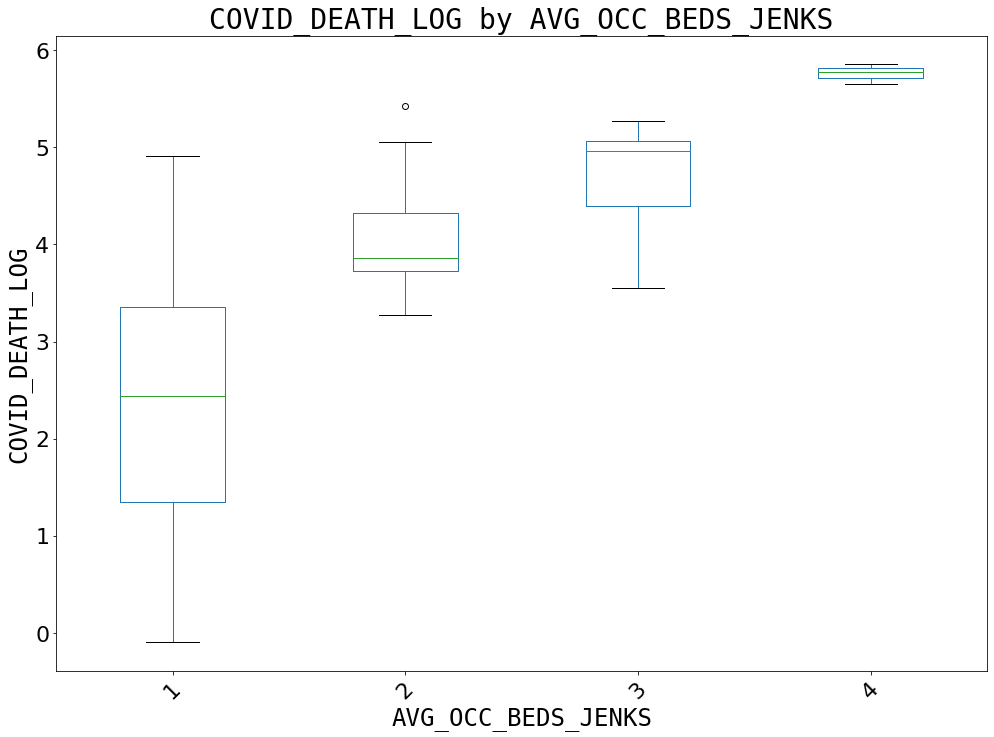

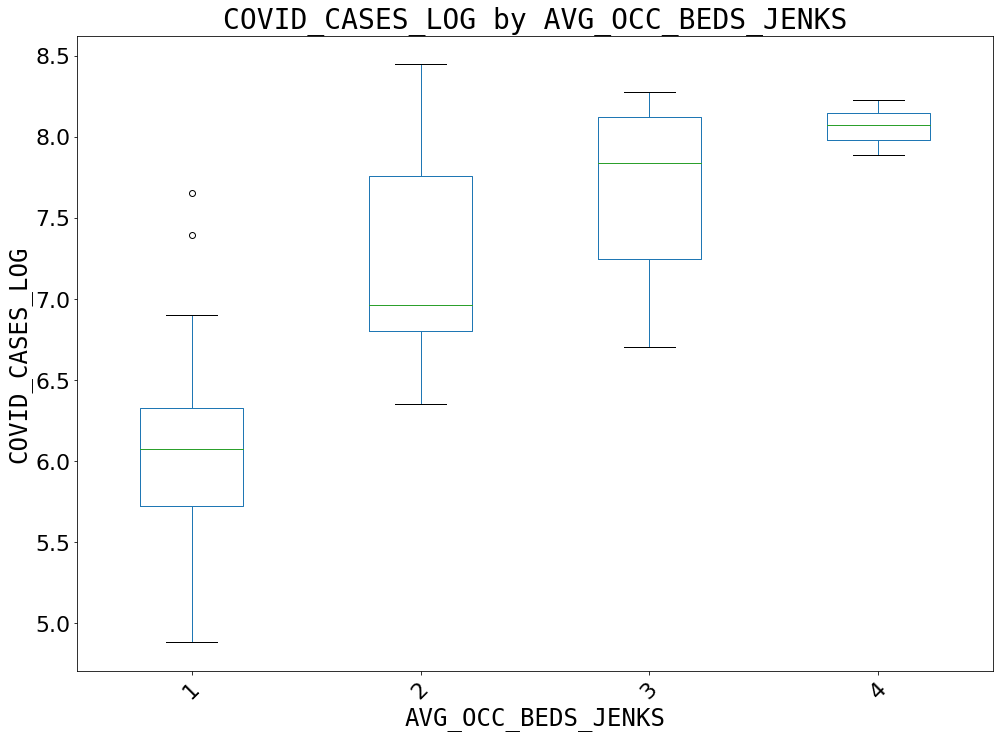

In [45]:
ny_covid=jenksClass(ny_covid,'AVG_OCC_BEDS',4)

boxplot('AVG_OCC_BEDS_JENKS','COVID_DEATH_LOG',ny_covid)

boxplot('AVG_OCC_BEDS_JENKS','COVID_CASES_LOG',ny_covid)

In [43]:
ny_covid.to_csv(r'C:\Users\16464\Desktop\AD\Centro\COVID\NY_COVID_DATA.csv')

[    0.    342.5   518.   1335.5 11454. ]
AVG_OCC_BEDS_QUAN


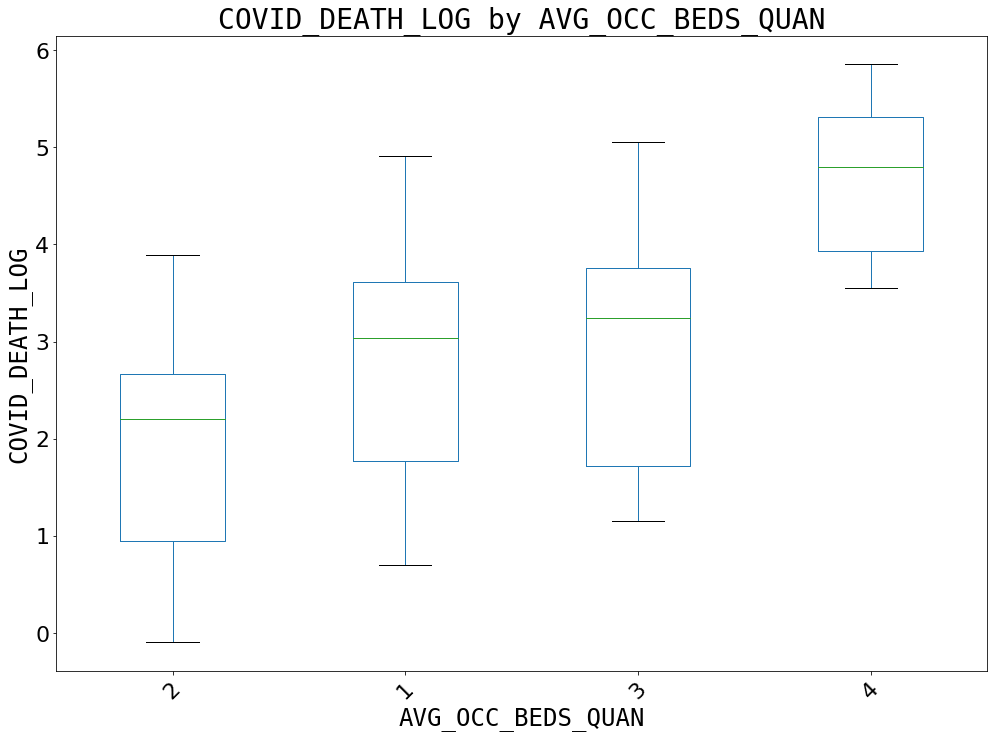

In [39]:
ny_covid=encode_quantiles(ny_covid,'AVG_OCC_BEDS')
boxplot('AVG_OCC_BEDS_QUAN','COVID_DEATH_LOG',ny_covid)

In [ ]:
ny_covid